In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Rest of your code goes here..

In [2]:
import tensorflow as tf

# Create a TensorFlow session and set the GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Specify the GPU device index to use (e.g., 1 for GPU 1)
    gpu_index = 1
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

# Rest of your code goes here...

In [1]:
import keras
import os
from keras.datasets import fashion_mnist, cifar100
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.utils import shuffle


In [7]:
#path="C:/Users/year1/Downloads/Dataset2"
#path="C:/Users/gaura/Downloads/Dataset2"
path="C:/Work2/data"

face_types=os.listdir(path)
print(face_types)

print("types of faces found:",len(face_types))

['Fake', 'Real']
types of faces found: 2


In [8]:
faces=[]

for item in face_types:
    all_faces=os.listdir(path + '/' + item)

    for face in all_faces:
        faces.append((item,str(path+'/'+item)+'/'+face))
        #print(faces[:1])

In [6]:
# Build a dataframe        
faces_df = pd.DataFrame(data=faces, columns=['face type', 'image'])
print(faces_df.head())
print(faces_df.tail())

  face type                              image
0      Fake  C:/Work2/data/Fake/000DmHuwCk.jpg
1      Fake  C:/Work2/data/Fake/002zSNaHxO.jpg
2      Fake  C:/Work2/data/Fake/0068uCvazN.jpg
3      Fake  C:/Work2/data/Fake/006JOjVQfD.jpg
4      Fake  C:/Work2/data/Fake/007ipsP3zJ.jpg
       face type                              image
189997      Real  C:/Work2/data/Real/ZzXQh6ieDP.jpg
189998      Real  C:/Work2/data/Real/ZZxyD6eKQA.jpg
189999      Real  C:/Work2/data/Real/zZYan2VV2B.jpg
190000      Real  C:/Work2/data/Real/zZyeu2Y7fW.jpg
190001      Real  C:/Work2/data/Real/ZZzD0gL408.jpg


In [ ]:
# ignore if resized exists
#creates resized folder
import cv2
import cv2
import os

#path = "C:/Users/year1/Downloads/Dataset2"
#path="C:/Users/gaura/Downloads/Dataset2"
path="D:/Work/data"
im_size = 227
batch_size = 380  # adjust batch size as needed

def image_generator():
    for i in face_types:
        data_path = os.path.join(path, str(i))
        filenames = os.listdir(data_path)
        for j in range(0, len(filenames), batch_size):
            batch_filenames = filenames[j:j+batch_size]
            batch_images = []
            batch_labels = []
            for f in batch_filenames:
                img = cv2.imread(os.path.join(data_path, f))
                if img is None:
                    print(f"Error: failed to read {os.path.join(data_path, f)}")
                    continue
                img = cv2.resize(img, (im_size, im_size))
                filename = os.path.splitext(f)[0] + '.jpg'  # change extension to .jpg
                filepath = os.path.join(data_path, 'resized_Alexnet', filename)  # create output path
                cv2.imwrite(filepath, img)  # write resized image to disk
                batch_images.append(filepath)  # append file path to batch
                batch_labels.append(i)
            yield batch_images, np.array(batch_labels)

# create output directories
for i in face_types:
    os.makedirs(os.path.join(path, str(i), 'resized_AlexNet'), exist_ok=True) # change for different network

# Example usage
gen = image_generator()
for i in range(101):  # load 10 batches
    batch_images, batch_labels = next(gen)
    print(f"Loaded batch {i+1} with {len(batch_images)} images")


In [ ]:
#ignore if h5 exists
#creates images.h5
import os 
import cv2 
import numpy as np 
import h5py 
#path = "C:/Users/year1/Downloads/Dataset2/" 
#path="C:/Users/gaura/Downloads/Dataset2"
path="C:/Work2/data"
im_size = 227 
images = [] 
for i in face_types: 
    data_path = os.path.join(path, str(i), 'Augmented') 
    filenames = os.listdir(data_path) 
    for f in filenames: 
        filepath = os.path.join(data_path, f) 
        images.append(filepath) 
with h5py.File('images_AlexNet2.h5', 'w') as f: 
    dset = f.create_dataset('images', shape=(len(images), im_size, im_size, 3), dtype='float16')
    for i, filepath in enumerate(images): 
        img = cv2.imread(filepath) 
        img = cv2.resize(img, (im_size, im_size)) 
        img = img.astype('float16') / 255.0 
        dset[i] = img 
with h5py.File('images_AlexNet2.h5', 'r') as f: 
    dset = f['images'] 
    for i in range(len(images)): 
        img = dset[i]

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert labels to numerical values using label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(faces_df['face type'].values)

# Perform one hot encoding on the numerical labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y.reshape(-1, 1))

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(256, (5,5), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu'))
model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu'))
model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

In [8]:
#path_test="C:/Users/year1/Downloads/Dataset_Copy_test"
#path_test="C:/Users/gaura/Downloads/Dataset_Copy_test3"
path_test="C:/WORK/Dataset_Copy_test3"
face_types_test=os.listdir(path_test)
print(face_types_test)

print("types of faces found:",len(face_types_test))

['Fake', 'Real']
types of faces found: 2


In [9]:
faces_test=[]

for item in face_types_test:
    all_faces_test=os.listdir(path_test + '/' + item)

    for face in all_faces_test:
        faces_test.append((item,str(path_test+'/'+item)+'/'+face))
        #print(faces[:1])

In [10]:
faces_df_test = pd.DataFrame(data=faces_test, columns=['face type', 'image'])
print(faces_df_test.head())
print(faces_df_test.tail())

  face type                                           image
0      Fake  C:/WORK/Dataset_Copy_test3/Fake/0052ETBQFB.jpg
1      Fake  C:/WORK/Dataset_Copy_test3/Fake/053UBPVSLY.jpg
2      Fake  C:/WORK/Dataset_Copy_test3/Fake/056F3HHA5C.jpg
3      Fake  C:/WORK/Dataset_Copy_test3/Fake/056XH8KUI0.jpg
4      Fake  C:/WORK/Dataset_Copy_test3/Fake/058KLRF8OA.jpg
     face type                                              image
1995      Real  C:/WORK/Dataset_Copy_test3/Real/67_0_0_2017010...
1996      Real  C:/WORK/Dataset_Copy_test3/Real/67_0_0_2017010...
1997      Real  C:/WORK/Dataset_Copy_test3/Real/67_0_0_2017010...
1998      Real  C:/WORK/Dataset_Copy_test3/Real/67_0_0_2017010...
1999      Real  C:/WORK/Dataset_Copy_test3/Real/67_0_0_2017010...


In [11]:
import cv2
import numpy as np
import os

#path = "C:/Users/year1/Downloads/Dataset_Copy_test"
#path ="C:/Users/gaura/Downloads/Dataset_Copy_test3"
path="C:/WORK/Dataset_Copy_test3"
im_size = 227
face_types = ['Fake','Real']

label_map_test = {label: idx for idx, label in enumerate(face_types)}

images_test = []
labels_test = []

for label in face_types:
    data_path = os.path.join(path, label)
    filenames = [os.path.join(data_path, f) for f in os.listdir(data_path)]
   
    for filename in filenames:
        img = cv2.imread(filename)
        img = cv2.resize(img, (im_size, im_size))
        images_test.append(img)
        labels_test.append(label_map_test[label])

images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.int32)

In [12]:
images_test = np.array(images_test)

images_test.shape

images_test = images_test.astype('float16') / 255.0

images_test.shape

#images = np.array(images, dtype='float32') / 255.0

(2000, 227, 227, 3)

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert labels to numerical values using label encoding
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(faces_df_test['face type'].values)

# Perform one hot encoding on the numerical labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot_test = onehot_encoder.fit_transform(y_test.reshape(-1, 1))

In [14]:
images_test, y_onehot_test = shuffle(images_test, y_onehot_test, random_state=7)

x_train,x_test,y_train,y_test = train_test_split(images_test, y_onehot_test, test_size=0.9, random_state=15)


processing 1.0 epoch 1
57/57 [==============================] - 9s 153ms/step - loss: 3.3846 - accuracy: 0.5061
processing 2.0 epoch 1
57/57 [==============================] - 9s 155ms/step - loss: 0.7013 - accuracy: 0.4939
processing 3.0 epoch 1
57/57 [==============================] - 9s 159ms/step - loss: 0.6934 - accuracy: 0.4939
processing 4.0 epoch 1
57/57 [==============================] - 9s 162ms/step - loss: 0.6922 - accuracy: 0.5067
processing 5.0 epoch 1
57/57 [==============================] - 9s 163ms/step - loss: 0.6913 - accuracy: 0.5061
processing 6.0 epoch 1
57/57 [==============================] - 9s 165ms/step - loss: 0.6888 - accuracy: 0.6311
processing 7.0 epoch 1
57/57 [==============================] - 10s 168ms/step - loss: 0.7179 - accuracy: 0.5061
processing 8.0 epoch 1
57/57 [==============================] - 10s 172ms/step - loss: 0.6949 - accuracy: 0.4939
processing 9.0 epoch 1
57/57 [==============================] - 10s 169ms/step - loss: 0.6944 - accura

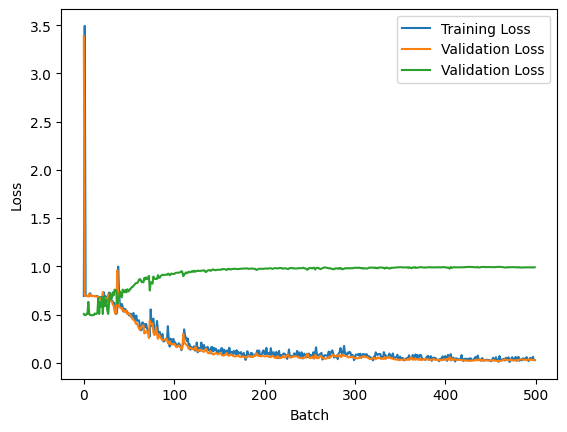

In [16]:
import h5py
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
# open the .h5 file and get the dataset shape
with h5py.File('images_AlexNet2.h5', 'r') as file:
    num_images = file['images'].shape[0]
batch_size = 190
num_epochs = 1

train_losses=[]
val_losses=[]


for epoch in range(num_epochs):
    for i in range(0, 95000, batch_size):
        with h5py.File('images_AlexNet2.h5', 'r') as file:
            fake_images_batch = file['images'][i:i+batch_size]
            real_images_batch = file['images'][95000+i:95000+i+batch_size]
            images_batch = np.concatenate([fake_images_batch, real_images_batch])
            fake_labels_batch = y_onehot[i:i+batch_size]
            real_labels_batch = y_onehot[95000+i:95000+i+batch_size]
            labels_batch = np.concatenate([fake_labels_batch, real_labels_batch])
            print("processing",(i/190)+1,"epoch",epoch+1)
            history=model.train_on_batch(images_batch, labels_batch)
            train_losses.append(history[0])
            val_loss=model.evaluate(x_test,y_test)
            val_losses.append(val_loss)

plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()           
           


In [17]:
test_loss, test_acc = model.evaluate(x_train, y_train)

7/7 [==============================] - 1s 149ms/step - loss: 0.0303 - accuracy: 0.9850


In [18]:
model.save('C:/Work2/model_AlexNet1.h5')

In [15]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(x_train)

# Convert the predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       111
           1       1.00      0.97      0.98        89

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



In [2]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('C:/Work2/model_AlexNet1.h5')

In [16]:
#path_test="C:/Users/year1/Downloads/Dataset_Copy_test"
#path_test="C:/Users/gaura/Downloads/Dataset_Copy_test3"
path_test="C:/WORK/Dataset_Copy_test4"
face_types_test=os.listdir(path_test)
print(face_types_test)

print("types of faces found:",len(face_types_test))

['Fake', 'Real']
types of faces found: 2


In [17]:
faces_test=[]

for item in face_types_test:
    all_faces_test=os.listdir(path_test + '/' + item)

    for face in all_faces_test:
        faces_test.append((item,str(path_test+'/'+item)+'/'+face))
        #print(faces[:1])

In [18]:
faces_df_test = pd.DataFrame(data=faces_test, columns=['face type', 'image'])
print(faces_df_test.head())
print(faces_df_test.tail())

  face type                                              image
0      Fake  C:/WORK/Dataset_Copy_test4/Fake/0052ETBQFB_aug...
1      Fake  C:/WORK/Dataset_Copy_test4/Fake/0052ETBQFB_aug...
2      Fake  C:/WORK/Dataset_Copy_test4/Fake/0052ETBQFB_aug...
3      Fake  C:/WORK/Dataset_Copy_test4/Fake/053UBPVSLY_aug...
4      Fake  C:/WORK/Dataset_Copy_test4/Fake/053UBPVSLY_aug...
     face type                                              image
5995      Real  C:/WORK/Dataset_Copy_test4/Real/67_0_0_2017010...
5996      Real  C:/WORK/Dataset_Copy_test4/Real/67_0_0_2017010...
5997      Real  C:/WORK/Dataset_Copy_test4/Real/67_0_0_2017010...
5998      Real  C:/WORK/Dataset_Copy_test4/Real/67_0_0_2017010...
5999      Real  C:/WORK/Dataset_Copy_test4/Real/67_0_0_2017010...


In [19]:
import cv2
import numpy as np
import os

#path = "C:/Users/year1/Downloads/Dataset_Copy_test"
#path ="C:/Users/gaura/Downloads/Dataset_Copy_test3"
path="C:/WORK/Dataset_Copy_test4"
im_size = 227
face_types = ['Fake','Real']

label_map_test = {label: idx for idx, label in enumerate(face_types)}

images_test = []
labels_test = []

for label in face_types:
    data_path = os.path.join(path, label)
    filenames = [os.path.join(data_path, f) for f in os.listdir(data_path)]
   
    for filename in filenames:
        img = cv2.imread(filename)
        img = cv2.resize(img, (im_size, im_size))
        images_test.append(img)
        labels_test.append(label_map_test[label])

images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.int32)

In [20]:
images_test = np.array(images_test)

images_test.shape

images_test = images_test.astype('float16') / 255.0

images_test.shape

#images = np.array(images, dtype='float32') / 255.0

(6000, 227, 227, 3)

In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert labels to numerical values using label encoding
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(faces_df_test['face type'].values)

# Perform one hot encoding on the numerical labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot_test = onehot_encoder.fit_transform(y_test.reshape(-1, 1))

In [22]:
images_test, y_onehot_test = shuffle(images_test, y_onehot_test, random_state=7)

x_train,x_test,y_train,y_test = train_test_split(images_test, y_onehot_test, test_size=0.9, random_state=15)


In [23]:
test_loss, test_acc = model.evaluate(x_train, y_train)

19/19 [==============================] - 2s 82ms/step - loss: 0.0319 - accuracy: 0.9850


In [24]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes,y_pred_classes)
auroc = roc_auc_score(y_test_classes,y_pred_classes)

print("Accuracy is =", accuracy*100,"%")
print("Precision is =", precision*100,"%")
print("Recall is =", recall*100,"%")
print("F1-Score is =", f1*100,"%")
print("AUROC is =", auroc*100,"%")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [25]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(x_train)

# Convert the predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       308
           1       1.00      0.97      0.98       292

    accuracy                           0.98       600
   macro avg       0.99      0.98      0.98       600
weighted avg       0.99      0.98      0.98       600



In [3]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import gradio as gr

C:\Users\arjun\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def predict_image(img):
    img_3d=img.reshape(-1,227,227,3)
    prediction=model.predict(img_3d)[0]
    return {face_types[i]: float (prediction[i]) for i in range(2)}

In [10]:
image=gr.inputs.Image(shape=(227,227))
label=gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=predict_image, inputs=image, outputs=label, capture_session=True).launch(debug="True")

C:\Users\arjun\anaconda3\envs\tf-gpu\lib\site-packages\gradio\inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\arjun\anaconda3\envs\tf-gpu\lib\site-packages\gradio\inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
C:\Users\arjun\anaconda3\envs\tf-gpu\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\arjun\anaconda3\envs\tf-gpu\lib\site-packages\gradio\outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)
C:\Users\arjun\AppData\Local\Temp\ipykernel_15376\3660934537.py:4: UserWarning: `capture_session` parameter is 

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
